vae2cls　オートエンコーダー ( net/lossクラス分離 )

参考文献　我妻幸長　「はじめてのディープラーニング２」

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch210929/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch210929/MiniCTorch_Prototype/notebook


In [4]:
! pip install lark-parser

In [5]:
import sys
sys.path.append("../")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch
import minictorch.generator as GN
import minictorch.converter as CV

サンプルデータ

In [6]:
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2
n_batch = 32

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()
t_train = digits_data.target
print(x_train.shape)

torch.Size([1797, 64])


サンプルデータの図化

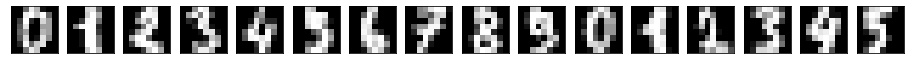

In [7]:
import matplotlib.pyplot as plt
n_img = 16

plt.figure( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

ニューラルネットワークの定義

In [8]:
import torch.distributions as td

"""
def reconstruction( y, t ):
  eps = 1.0e-7
  e = t * torch.log(y+eps) + (1-t) * torch.log(1-y+eps) 
  z = torch.sum(e) / len(y)
  return z;

def kl_divergence( mean, log_var ):
  g = 1 + log_var - mean**2 - torch.exp( log_var )
  y = 0.5 * torch.sum( g ) / len(mean)
  return y

# original class
class Net1(torch.nn.Module):
  def __init__( self, n_in, n_mid, n_out, n_z, e ):
    super(Net1, self).__init__()
    self.fc1 = nn.Linear(n_in, n_mid)
    #self.bn1 = nn.BatchNorm1d(n_mid)
    self.fc2_mean = nn.Linear(n_mid, n_z)
    self.fc2_var  = nn.Linear(n_mid, n_z)
    self.fc3 = nn.Linear(n_z  ,n_mid)
    self.fc4 = nn.Linear(n_mid,n_out)
    #self.drop1 = nn.Dropout(p=0.2)
    self.eps = e

    nn.init.constant_(self.fc1.bias,0)
    nn.init.constant_(self.fc2_mean.bias,0)
    nn.init.constant_(self.fc2_var.bias,0)
    nn.init.constant_(self.fc3.bias,0)
    nn.init.constant_(self.fc4.bias,0)
  
  def forward( self, x ):
    # encoder
    self.x2 = F.relu( self.fc1(x) )
    #self.x2 = self.bn1(self.x1)
    self.mean    = self.fc2_mean(self.x2)
    self.log_var = self.fc2_var(self.x2)

    # reparametrization
    #eps = torch.randn( n_batch, n_z )
    eps = torch.randn( self.mean.shape )
    #nm = tdist.Normal( 0.0, 1.0 ) #torch.tensor([0.0]), torch.tensor([1.0]))
    #eps = nm.sample([ n_batch, n_z ])
    #eps = torch.normal(0.0,1.0,[32,2])
    #print("eps",eps.size(),eps)
    self.z = self.mean + eps * torch.exp( 0.5 * self.log_var )
    #self.z = self.mean + self.eps * torch.exp( 0.5 * self.log_var )

    # decoder
    self.y2 = F.relu( self.fc3(self.z) )
    #self.y2 = self.drop1(self.y1)
    y = torch.sigmoid( self.fc4(self.y2) )
    self.out = y 
    
    e1 = reconstruction( y, x )
    e2 = kl_divergence( self.mean, self.log_var )
    #print("e1,e2",e1,e2)
    self.loss1=e1
    self.loss2=e2
    
    return -(e1+e2)
"""
class VAE(torch.nn.Module):
  
  class Net(torch.nn.Module):
    def __init__( self, n_in, n_mid, n_out, n_z, e ):
      super().__init__()
      print("create net class")
      self.fc1 = nn.Linear(n_in, n_mid)
      self.bn1 = nn.BatchNorm1d(n_mid)
      self.fc2_mean = nn.Linear(n_mid, n_z)
      self.fc2_var  = nn.Linear(n_mid, n_z)
      self.fc3 = nn.Linear(n_z  ,n_mid)
      self.fc4 = nn.Linear(n_mid,n_out)
      #self.drop1 = nn.Dropout(p=0.2)
      self.eps = e
    
      nn.init.constant_(self.fc1.bias,0)
      nn.init.constant_(self.fc2_mean.bias,0)
      nn.init.constant_(self.fc2_var.bias,0)
      nn.init.constant_(self.fc3.bias,0)
      nn.init.constant_(self.fc4.bias,0)
    
    def forward( self, x ):
      # encoder
      self.x1 = F.relu( self.fc1(x) )
      self.x2 = self.bn1( self.x1 )
      m1 = self.fc2_mean( self.x2 )
      v1 = self.fc2_var( self.x2 )
      self.mean = m1;
      self.log_var = v1;

      # reparametrization
      self.std = torch.exp( 0.5 * self.log_var )
      q_z = td.normal.Normal( self.mean, self.std )
      self.z = q_z.rsample()

      # decoder
      self.y2 = F.relu( self.fc3(self.z) )
      #self.y2 = self.drop1(self.y1)
      y = torch.sigmoid( self.fc4(self.y2) )
      self.out = y 

      #return y, m1, v1
      return y, q_z
  
  class Loss(torch.nn.Module):
    def __init__(self):
      super().__init__()
      print("create loss class")

    def forward( self, y, x, q_z ):
      #vae1
      #e1 = reconstruction( y, x )
      #e2 = kl_divergence( mean, log_var )
      # vae2
      e1 = F.binary_cross_entropy( y , x, reduction="mean" )
      #e1 = self.bce1(y, x)
      p_z = td.normal.Normal( torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale) )
      e2  = td.kl_divergence( q_z, p_z ).sum()

      self.loss1 = e1
      self.loss2 = e2
      #print("e1,e2",e1,e2)
      #return -(e1+e2)
      return (e1+e2)

  def __init__( self, n_in, n_mid, n_out, n_z, e ):
    super( VAE, self ).__init__()
    print("create vae class")
    self.net  = self.Net( n_in, n_mid, n_out, n_z, e )
    self.loss = self.Loss()

  def forward( self, x ):
    # vae1
    #y, m1, v1 = self.net(x)
    #output = self.loss( y, x, m1, v1 )
    # vae2
    y, q_z = self.net(x)
    output = self.loss( y, x, q_z )
    return output

In [9]:
def generate_json( json_path, input, e ):

    #model = Net( n_in, n_mid, n_out, n_z, e )
    model = VAE( n_in, n_mid, n_out, n_z, e )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [10]:
torch.manual_seed( 1 )

project = 'vae2cls'
json_path = './network/' + project +'.json'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#print(type(x))
#x.requires_grad = True

e = torch.randn( n_batch, 2 )
#print("eps",e)

model = generate_json( json_path, x, e )

create vae class
create net class
create loss class
[SAVE] ./network/vae2cls.json
skip: VAE/Net[net]/Linear[fc1]/weight/223
skip: VAE/Net[net]/Linear[fc1]/weight/223
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/222
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/222
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/222
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/222
skip: VAE/Net[net]/Linear[fc2_mean]/weight/221
skip: VAE/Net[net]/Linear[fc2_mean]/weight/221
skip: VAE/Net[net]/Linear[fc2_var]/weight/220
skip: VAE/Net[net]/Linear[fc2_var]/weight/220
skip: VAE/Net[net]/Linear[fc3]/weight/219
skip: VAE/Net[net]/Linear[fc3]/weight/219
skip: VAE/Net[net]/Linear[fc4]/weight/218
skip: VAE/Net[net]/Linear[fc4]/weight/218


/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:985: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 1 element(s) (out of 1) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.00352323055267334 (1.3834868669509888 vs. 1.3799636363983154), which occurred at index 0.
  _module_class,


In [11]:
CV.convert_json( project, "./src", model, x, json_path )

[JSON] ./network/vae2cls.json
{'name': 'VAE/Net[net]/Linear[fc1]/weight/225', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'VAE/Net[net]/Linear[fc1]/bias/224', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'VAE/Net[net]/BatchNorm1d[bn1]/weight/231', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 5}
{'name': 'VAE/Net[net]/BatchNorm1d[bn1]/bias/230', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 6}
{'name': 'VAE/Net[net]/BatchNorm1d[bn1]/running_mean/229', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 7}
{'name': 'VAE/Net[net]/BatchNorm1d[bn1]/running_var/228', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 8}
{'name': 'VAE/Net[net]/Linear[fc2_mean]/weight/234', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': 

In [12]:
# check code
print(x.shape)
with torch.set_grad_enabled(True):
  model.train()
  output = model( x )
  print("output",output)
  output.backward()
  
  #print("output",output.grad)
  """
  print("x1",model.x1)
  print("x2",model.x2)
  print("z",model.z)
  print("y1",model.y1)
  print("y2",model.y2)
  print("output",model.out)
  print("fc1_weigth_grad",model.fc1.weight.grad)
  print("fc1_bias_grad",model.fc1.bias.grad)
  print("bn1_w_grad",model.bn1.weight.grad)
  print("bn1_b_grad",model.bn1.bias.grad)
  print("fc3_weigth_grad",model.fc3.weight.grad)
  print("fc3_bias_grad",model.fc3.bias.grad)
  print("fc4_weigth_grad",model.fc4.weight.grad)
  print("fc4_bias_grad",model.fc4.bias.grad)
  """
  print("input_grad",x.grad)

torch.Size([32, 64])
output tensor(14.9651, grad_fn=<AddBackward0>)
input_grad None


In [13]:
!g++ -std=c++14 ./src/vae2cls.cpp ./src/vae2cls_param.cpp -D_NOTEBOOK -I ../../../xtensor -lcblas -o ./src/vae2cls

In [14]:
!./src/vae2cls

### forward computation ...
{ 14.965855}
### backward computation ...
input_grad{{-0.020495,  0.015118,  0.03877 , ...,  0.025979,  0.015628, -0.045254},
 {-0.416933, -0.82619 ,  0.427101, ...,  0.013256, -0.770619, -0.718495},
 { 0.011096, -0.120717, -0.074545, ..., -0.040067, -0.132613, -0.197302},
 ..., 
 {-0.028624, -0.091046, -0.005484, ..., -0.10248 , -0.13534 , -0.051647},
 {-0.018367,  0.01007 ,  0.035738, ...,  0.019181,  0.004711, -0.040581},
 { 0.200831, -0.396491,  0.115302, ..., -0.129249, -0.42721 , -0.206022}}


学習の実行(python)

In [20]:
torch.manual_seed( 1 )

epoch_num = 200
batch_size = 32
#interval = 5  # 経過の表示間隔

e = torch.randn( batch_size, 2 )
#print("eps",e)

vae = VAE( n_in, n_mid, n_out, n_z, e )
vae.train()

lr = 0.01
type=1
if type==1:
  opt = torch.optim.SGD( vae.parameters(), lr)
  #opt = torch.optim.Adagrad( vae.parameters(), lr)
if type==2:
  opt = torch.optim.Adam( vae.parameters(), lr )

epoch_loss1 = []
epoch_loss2 = []

l_batch = len(x_train) // batch_size  # 1エポックあたりのバッチ数
print("batch",l_batch,len(x_train),batch_size)

for i in range(epoch_num):
        
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    total_loss = 0.0
    for j in range(l_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        x_mb = x_train[mb_index, :]
        #x_mb.requires_grad = True
        #print("x_mb",x_mb.shape)
        
        # 順伝播と逆伝播
        loss = vae( x_mb )
        #print("loss",loss)
        total_loss += loss;

        opt.zero_grad()
        loss.backward()
        #forward_propagation(x_mb)
        #backpropagation(x_mb)
        
        # 重みとバイアスの更新
        opt.step()
        #print("EPOCH: {} {} loss: {}".format(i,j, loss))
        #epoch_loss.append( loss )
        #update_params()

    # -- 誤差を求める --
    print("EPOCH: {} loss: {}".format(i, total_loss))
    #epoch_loss.append( total_loss )

    x2 = x_train.clone().detach()
    torch.reshape( x2, (-1,n_in) )
    #print(x2.shape)

    vae.eval()
    loss = vae( x2 )
    print("loss", loss, vae.loss.loss1, vae.loss.loss2 )
    #print("out shape", vae.net.out.shape)
    if type==1:
      epoch_loss1.append( loss )
    if type==2:
      epoch_loss2.append( loss )


create vae class
create net class
create loss class
batch 56 1797 32
EPOCH: 0 loss: 80.01183319091797
loss tensor(2.4191, grad_fn=<AddBackward0>) tensor(0.6991, grad_fn=<BinaryCrossEntropyBackward>) tensor(1.7200, grad_fn=<SumBackward0>)
EPOCH: 1 loss: 48.426029205322266
loss tensor(0.8897, grad_fn=<AddBackward0>) tensor(0.6971, grad_fn=<BinaryCrossEntropyBackward>) tensor(0.1926, grad_fn=<SumBackward0>)
EPOCH: 2 loss: 39.09797668457031
loss tensor(0.7648, grad_fn=<AddBackward0>) tensor(0.6955, grad_fn=<BinaryCrossEntropyBackward>) tensor(0.0693, grad_fn=<SumBackward0>)
EPOCH: 3 loss: 38.937469482421875
loss tensor(0.7277, grad_fn=<AddBackward0>) tensor(0.6934, grad_fn=<BinaryCrossEntropyBackward>) tensor(0.0343, grad_fn=<SumBackward0>)
EPOCH: 4 loss: 38.81275939941406
loss tensor(0.7094, grad_fn=<AddBackward0>) tensor(0.6917, grad_fn=<BinaryCrossEntropyBackward>) tensor(0.0177, grad_fn=<SumBackward0>)
EPOCH: 5 loss: 38.70213317871094
loss tensor(0.6995, grad_fn=<AddBackward0>) tensor(

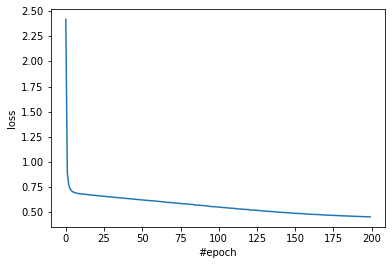

In [21]:
fig = plt.figure()
ax = fig.add_subplot()
if type==1:
  ax.plot(list(range(len(epoch_loss1))), epoch_loss1)
if type==2:
  ax.plot(list(range(len(epoch_loss2))), epoch_loss2)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

O (1797, 64)


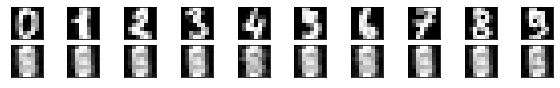

In [22]:
n_img2=10
#x3=x[:n_img2]
x2 = x_train.clone().detach()
x3 = x2[:n_img2]

torch.reshape( x2, (-1,n_in) )

loss = vae( x2 )

o = vae.net.out.to('cpu').detach().numpy().copy()
print("O",o.shape)

plt.figure( figsize=(10,2))
for i in range(n_img2):
  #input image
  ax = plt.subplot(3,n_img2,i+1)
  plt.imshow( x3[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #output image
  ax = plt.subplot(3,n_img2,i+1+n_img2)
  plt.imshow( o[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

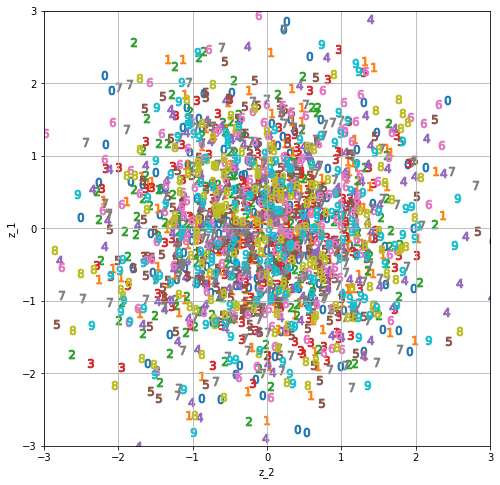

In [23]:
t2 = t_train #[:n_batch]

x2 = x_train.clone().detach()
torch.reshape( x2, (-1,n_in) )
loss = vae( x2 )

plt.figure(figsize=(8,8))
for i in range(10):
  zt = vae.net.z[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker,s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

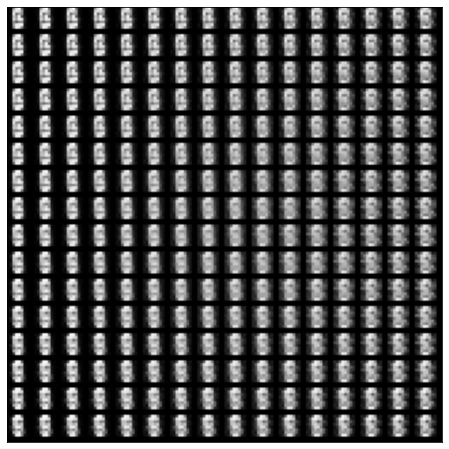

torch.Size([32, 64])


In [24]:
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( vae.net.fc3(zz) )
      o = torch.sigmoid( vae.net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()

print(x.shape)

学習の実行(C++)

In [26]:
!g++ -std=c++14 ./src/vae2cls.cpp ./src/vae2cls_param.cpp ./src/vae1_data.cpp ./src/vae2cls_train.cpp -D_NOTEBOOK -I ../../../xtensor -lcblas -o ./src/vae2cls_train

In [27]:
!./src/vae2cls_train

indata shape 1797,64
batch number 56,32
epoch_num : 200
total_loss 0 loss-75.8951
epoch 0 - loss { 2.563507} (  0.699438 , { 1.864069} ) 
total_loss 1 loss-41.0151
epoch 1 - loss { 1.404403} (  0.697458 , { 0.706945} ) 
total_loss 2 loss-39.8375
epoch 2 - loss { 1.027485} (  0.695124 , { 0.332361} ) 
total_loss 3 loss-39.4058
epoch 3 - loss { 0.896758} (  0.693759 , { 0.202999} ) 
total_loss 4 loss-39.133
epoch 4 - loss { 0.82046 } (  0.691766 , { 0.128694} ) 
total_loss 5 loss-38.896
epoch 5 - loss { 0.787949} (  0.689882 , { 0.098067} ) 
total_loss 6 loss-38.7528
epoch 6 - loss { 0.747111} (  0.687792 , { 0.059318} ) 
total_loss 7 loss-38.6198
epoch 7 - loss { 0.74312 } (  0.686225 , { 0.056896} ) 
total_loss 8 loss-38.464
epoch 8 - loss { 0.717946} (  0.684516 , { 0.03343 } ) 
total_loss 9 loss-38.3833
epoch 9 - loss { 0.718924} (  0.683011 , { 0.035913} ) 
total_loss 10 loss-38.2593
epoch 10 - loss { 0.705444} (  0.681152 , { 0.024293} ) 
total_loss 11 loss-38.168
epoch 11 - loss {

c++ からの出力ファイルの読み込み

In [28]:
# load out file
f = open('./src/vae2cls.out', 'r')
epoch_loss = []
datalist = f.readlines()
for data in datalist:
  epoch_loss.append( float(data) )
f.close()

print("epoch =", len(epoch_loss))
print( epoch_loss)

# load pred file
f2 = open('./src/vae2cls.pred', 'r')

datalist = f2.readlines()

n1 = 10
n2 = 64
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    n1 = int(ds[0])
    n2 = int(ds[1])
    global v_pred
    v_pred = np.zeros( (n1,n2))
  else:
    for i in range(n2):
      v_pred[k-1,i] = float(ds[i])
  k = k+1

f2.close()

# load z file
f3 = open('./src/vae2cls.z', 'r')

datalist = f3.readlines()
n1 = 100
n2 = 2
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    nz1 = int(ds[0])
    nz2 = int(ds[1])
    z_pred = np.zeros( (nz1,nz2))
  else:
    z_pred[k-1,0] = float(ds[0])
    z_pred[k-1,1] = float(ds[1])
  k = k+1

f3.close()

print("z =", nz1,nz2 )
#print(z_pred)

epoch = 200
[2.563507, 1.404403, 1.027485, 0.896758, 0.82046, 0.787949, 0.747111, 0.74312, 0.717946, 0.718924, 0.705444, 0.69837, 0.691288, 0.688803, 0.689377, 0.681089, 0.678489, 0.6767, 0.672785, 0.670673, 0.668945, 0.666261, 0.6638, 0.663538, 0.660724, 0.66086, 0.657382, 0.656042, 0.653594, 0.652721, 0.651737, 0.649095, 0.648638, 0.646525, 0.645415, 0.643505, 0.64197, 0.640925, 0.639504, 0.638422, 0.635943, 0.634938, 0.632411, 0.632118, 0.630277, 0.629431, 0.628477, 0.626384, 0.624489, 0.623028, 0.622419, 0.621225, 0.620016, 0.618472, 0.616355, 0.615898, 0.612873, 0.6114, 0.609578, 0.60866, 0.608695, 0.606105, 0.603854, 0.603877, 0.602318, 0.601563, 0.599075, 0.597616, 0.595825, 0.595363, 0.59372, 0.592919, 0.590585, 0.589414, 0.589288, 0.587386, 0.583898, 0.582531, 0.583323, 0.580708, 0.580303, 0.578087, 0.577192, 0.576452, 0.573554, 0.573871, 0.569936, 0.569322, 0.568732, 0.566606, 0.565247, 0.563121, 0.56365, 0.561665, 0.560036, 0.559853, 0.55747, 0.554858, 0.554775, 0.552389, 0.

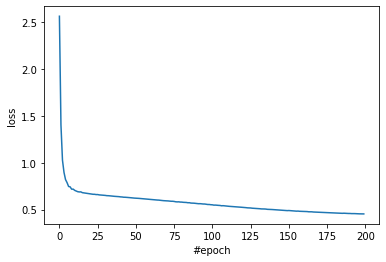

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

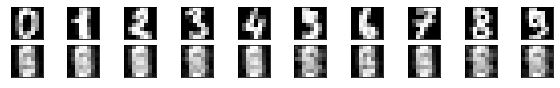

In [30]:
n_img5 = 10
x2 = x[:n_img5]

plt.figure( figsize=(10,2))
for i in range(n_img5):
  # input image
  ax = plt.subplot(3,n_img5,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # output image
  ax = plt.subplot(3,n_img5,i+1+n_img5)
  plt.imshow( v_pred[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

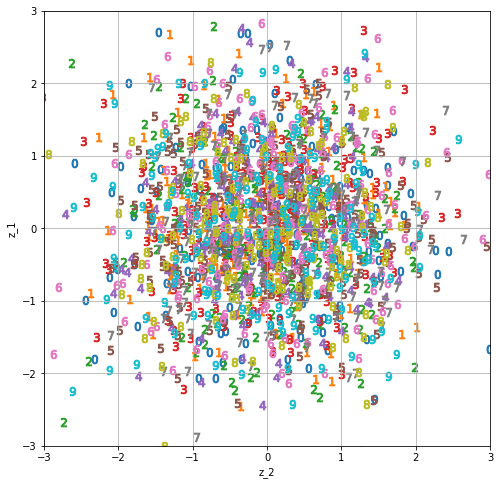

In [31]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = z_pred[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter( z_2.tolist(),  z_1.tolist(), marker=marker,s=75 )

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

In [32]:
print(x.shape)

torch.Size([32, 64])
